### LIBRARY IMPORTING


In [1]:
#GENERAL
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#PATH PROCESS
import os
from pathlib import Path
#IMAGE PROCESS
import cv2
#MACHINE LEARNING
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Reshape, Dense,Flatten, GaussianNoise
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

c:\Users\jakub\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\jakub\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


Let's try RGB histogram approach, to see whether there are some similarities in terms of RGB values between galaxies

Let's load necessary data

In [ ]:
train_paths=pd.read_pickle('../data/train_path_series.pkl')


KeyboardInterrupt



We will apply a function, which generates histogram. It is based on our image path

In [ ]:
def plot_rgb_histograms(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    colors = ('r', 'g', 'b')
    plt.figure(figsize=(12, 4))
    plt.title(f'RGB Histogram for {os.path.basename(image_path)}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    for i, color in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
        plt.xlim([0, 256])
    plt.show()

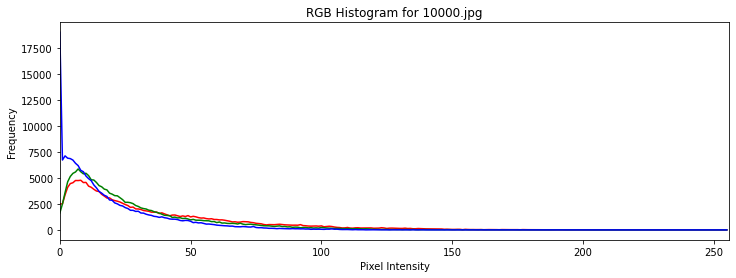

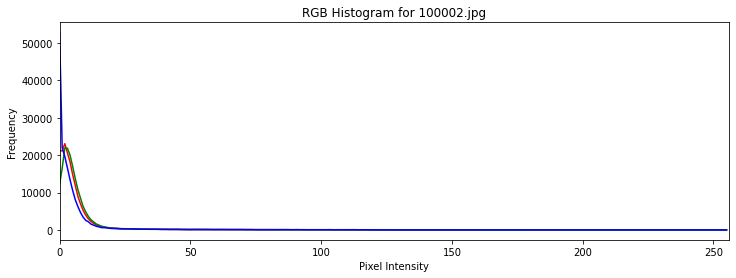

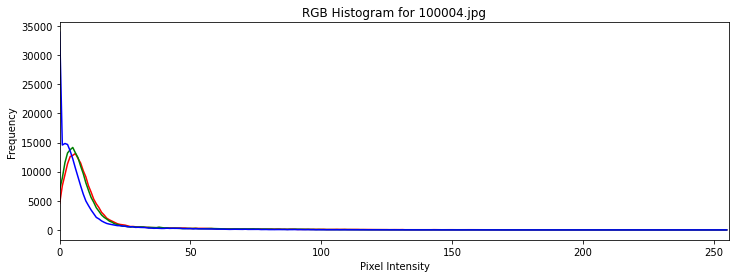

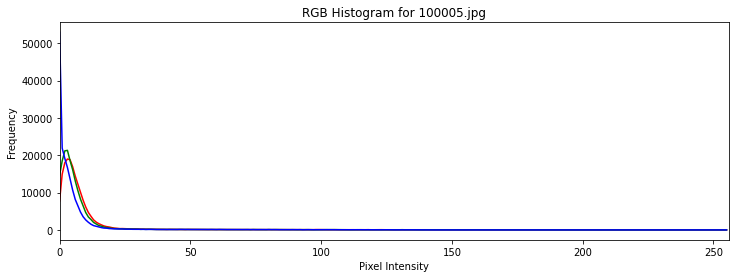

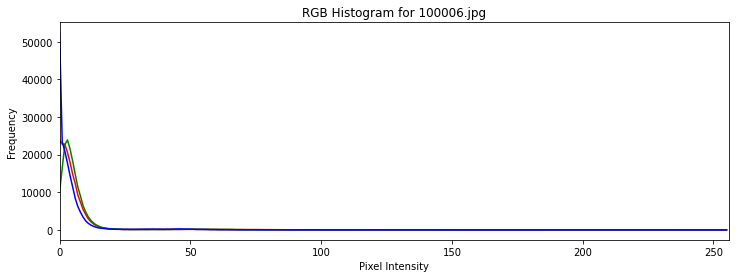

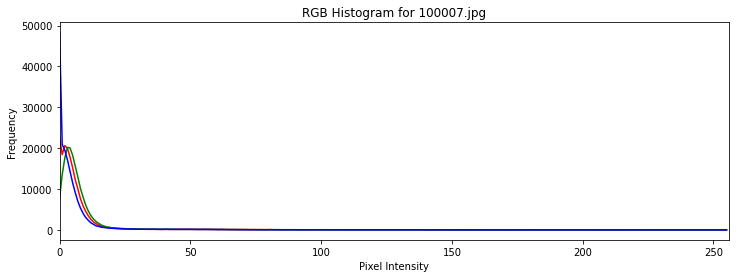

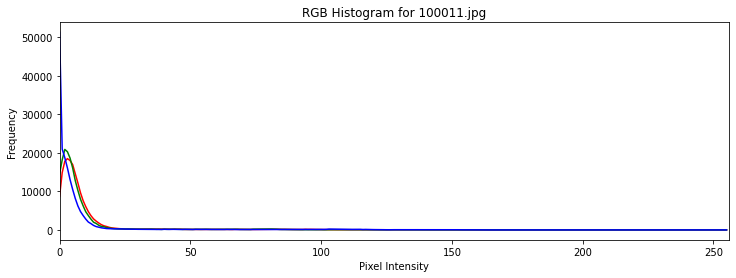

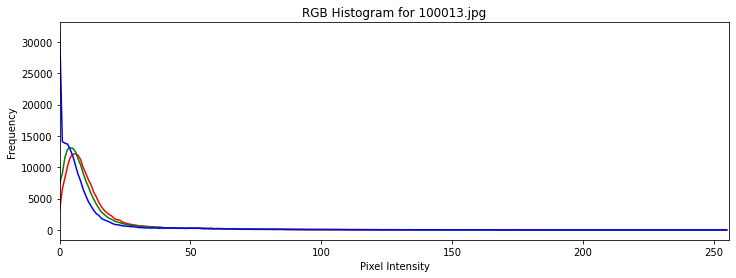

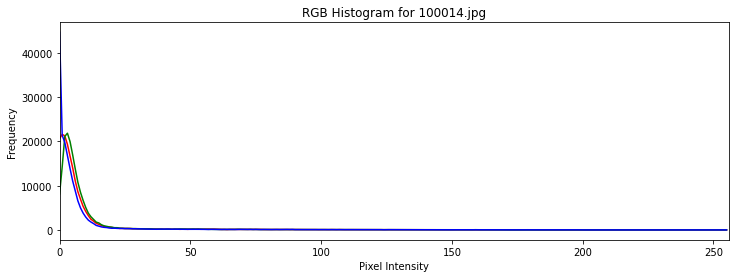

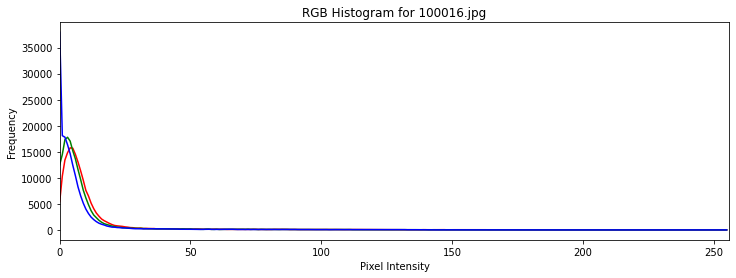

In [ ]:
for train_path in train_paths.loc[1:10]:
    plot_rgb_histograms(train_path)

As we can see all of them look pretty similar. That's propably because of it's black background

In [ ]:
from sklearn.manifold import MDS


def calculate_rgb_histogram(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Image at path {image_path} could not be loaded.")
        return None
    hist_features = []
    for i in range(3):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        hist = hist.flatten()
        hist_features.extend(hist)
    return hist_features

# Calculate histograms for all images
histograms = [calculate_rgb_histogram(image_path) for image_path in train_paths.loc[1:10000,]]

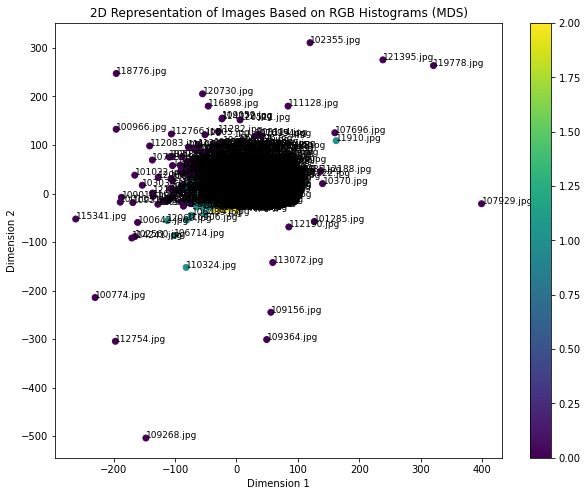

In [ ]:
# Normalize the histograms
scaler = StandardScaler()
histograms_normalized = scaler.fit_transform(histograms)

# Perform k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(histograms_normalized)

# Perform MDS to reduce dimensions to 2D
mds = MDS(n_components=2, random_state=42)
histograms_2d_mds = mds.fit_transform(histograms_normalized)

# Plot the 2D representation of the images
plt.figure(figsize=(10, 8))
plt.scatter(histograms_2d_mds[:, 0], histograms_2d_mds[:, 1], c=clusters, cmap='viridis', marker='o')
for i, image_path in enumerate(train_paths.loc[1:10000,]):
    plt.text(histograms_2d_mds[i, 0], histograms_2d_mds[i, 1], os.path.basename(image_path), fontsize=9)
plt.title('2D Representation of Images Based on RGB Histograms (MDS)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar()
plt.show()

Let's take 3 examples from different clusters to see some similarities or differences between them

In [ ]:
image_paths=["..\\images_gz2\\images\\100774.jpg","..\\images_gz2\\images\\100108.jpg","..\\images_gz2\\images\\101801.jpg"]

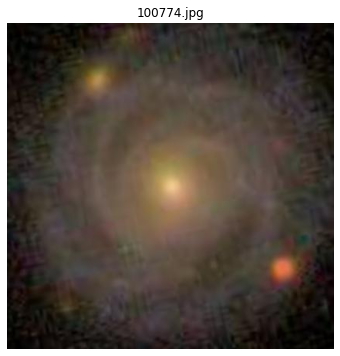

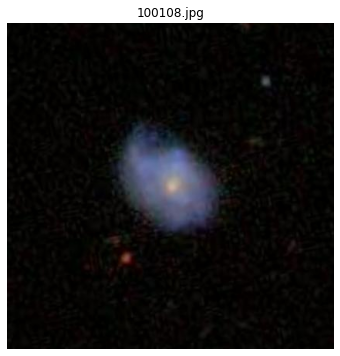

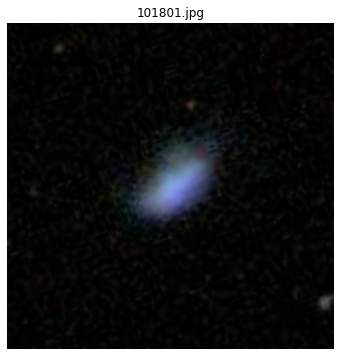

In [ ]:
for image_path in image_paths:
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.title(os.path.basename(image_path))
        plt.axis('off')
        plt.show()

Let's see how yellow cluster images look like

In [ ]:
image_paths_2=["..\\images_gz2\\images\\100774.jpg","..\\images_gz2\\images\\101022.jpg","..\\images_gz2\\images\\100113.jpg","..\\images_gz2\\images\\100966.jpg"]

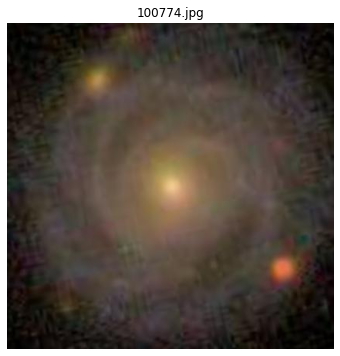

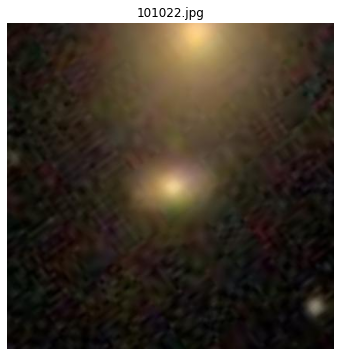

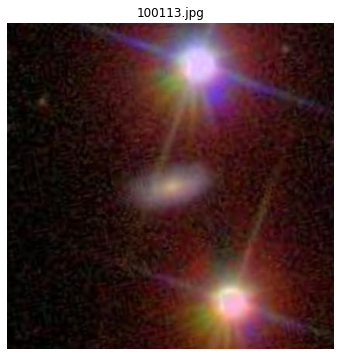

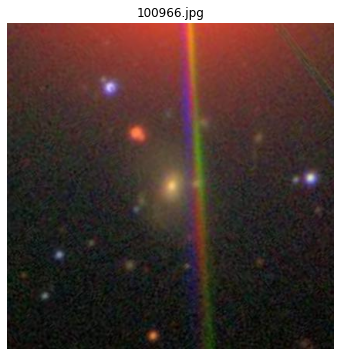

In [ ]:
for image_path in image_paths_2:
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.title(os.path.basename(image_path))
        plt.axis('off')
        plt.show()

## BAG OF VISUAL WORDS

Firstly, we will focus on feature extraction

In [ ]:
sift = cv2.SIFT_create()
descriptors_list = []
correct_paths=[]

In [4]:
train_paths_2=train_paths.loc[1:1000]

for image_path in train_paths_2:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        keypoints, descriptors = sift.detectAndCompute(image, None)
        if descriptors is not None and len(descriptors) > 0:
            descriptors_list.append(descriptors)
            correct_paths.append(image_path)
        else:
            print(f"Warning: No descriptors found for image at path {image_path}")
    else:
        print(f"Warning: Image at path {image_path} could not be loaded.")


NameError: name 'train_paths' is not defined

Vocabulary creation

In [ ]:
descriptors_list = np.vstack(descriptors_list)

In [ ]:
# Debugging: Check the shape of the descriptors list
print("Shape of descriptors list:", descriptors_list.shape)

# Step 2: Vocabulary Creation
k = 50  # Number of visual words
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(descriptors_list)
vocabulary = kmeans.cluster_centers_

# Debugging: Check if the vocabulary is created correctly
print("Shape of vocabulary:", vocabulary.shape)

Shape of descriptors list: (28887, 128)
Shape of vocabulary: (50, 128)


Computing histograms with visual words

In [ ]:
def compute_histogram(image_path, kmeans, k):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        keypoints, descriptors = sift.detectAndCompute(image, None)
        if descriptors is not None and len(descriptors) > 0:
            print(f"Descriptors shape for {image_path}: {descriptors.shape}")
            visual_words = kmeans.predict(descriptors)
            histogram, _ = np.histogram(visual_words, bins=np.arange(0, k + 1))
            return histogram
        else:
            print(f"Warning: No descriptors found for image at path {image_path}")
    else:
        print(f"Warning: Image at path {image_path} could not be loaded.")
    return np.zeros(k)

In [ ]:
histograms = np.array([compute_histogram(image_path, kmeans, k) for image_path in correct_paths])

Descriptors shape for ..\images_gz2\images\10000.jpg: (53, 128)
Descriptors shape for ..\images_gz2\images\100002.jpg: (21, 128)
Descriptors shape for ..\images_gz2\images\100004.jpg: (18, 128)
Descriptors shape for ..\images_gz2\images\100005.jpg: (8, 128)
Descriptors shape for ..\images_gz2\images\100006.jpg: (11, 128)


Descriptors shape for ..\images_gz2\images\100007.jpg: (71, 128)
Descriptors shape for ..\images_gz2\images\100011.jpg: (4, 128)
Descriptors shape for ..\images_gz2\images\100013.jpg: (28, 128)
Descriptors shape for ..\images_gz2\images\100014.jpg: (12, 128)
Descriptors shape for ..\images_gz2\images\100016.jpg: (25, 128)
Descriptors shape for ..\images_gz2\images\100017.jpg: (15, 128)
Descriptors shape for ..\images_gz2\images\100018.jpg: (61, 128)
Descriptors shape for ..\images_gz2\images\10002.jpg: (41, 128)
Descriptors shape for ..\images_gz2\images\100021.jpg: (36, 128)
Descriptors shape for ..\images_gz2\images\100022.jpg: (60, 128)
Descriptors shape for ..\images_gz2\images\100024.jpg: (31, 128)
Descriptors shape for ..\images_gz2\images\100025.jpg: (11, 128)
Descriptors shape for ..\images_gz2\images\100028.jpg: (15, 128)
Descriptors shape for ..\images_gz2\images\100031.jpg: (10, 128)
Descriptors shape for ..\images_gz2\images\100034.jpg: (21, 128)
Descriptors shape for ..\im

In [ ]:
print("Shape of histograms:", histograms.shape)

Shape of histograms: (998, 50)


In [ ]:
scaler = StandardScaler()
histograms_normalized = scaler.fit_transform(histograms)

In [ ]:
num_clusters = 3
kmeans_cluster = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans_cluster.fit_predict(histograms_normalized)

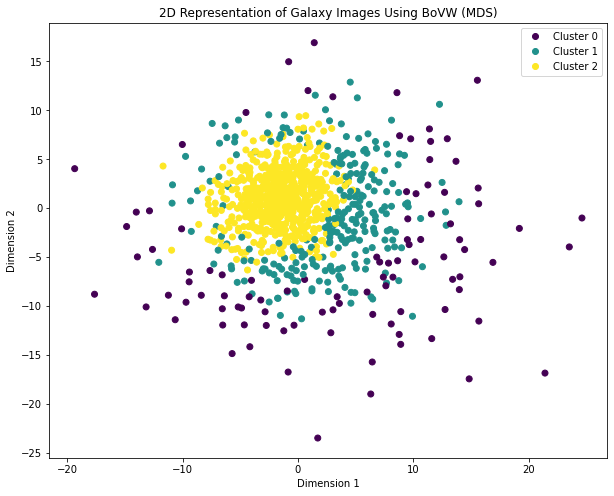

In [ ]:
mds = MDS(n_components=2, random_state=42)
histograms_2d_mds = mds.fit_transform(histograms_normalized)

# Plot the 2D representation of the images
plt.figure(figsize=(10, 8))
scatter = plt.scatter(histograms_2d_mds[:, 0], histograms_2d_mds[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('2D Representation of Galaxy Images Using BoVW (MDS)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {i}' for i in range(num_clusters)])
plt.show()

Now we will use different clustering -> Agglomerative clustering

In [ ]:
sift = cv2.SIFT_create()
descriptors_list = []

for image_path in train_paths_2:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        keypoints, descriptors = sift.detectAndCompute(image, None)
        if descriptors is not None and len(descriptors) > 0:
            descriptors_list.append(descriptors)
        else:
            print(f"Warning: No descriptors found for image at path {image_path}")
    else:
        print(f"Warning: Image at path {image_path} could not be loaded.")

# Check if descriptors list contains elements
if len(descriptors_list) == 0:
    raise ValueError("No descriptors found. Ensure images are loaded correctly and contain detectable features.")

# Flatten the list of descriptors into a 2D array
descriptors_list = np.vstack(descriptors_list)

# Debugging: Check the shape of the descriptors list
print("Shape of descriptors list:", descriptors_list.shape)


Shape of descriptors list: (28887, 128)


In [ ]:
# Step 2: Vocabulary Creation
k = 50  # Number of visual words
# Using Agglomerative Clustering to create the vocabulary
agglo_cluster = AgglomerativeClustering(n_clusters=k)
visual_words = agglo_cluster.fit_predict(descriptors_list)
vocabulary = np.zeros((k, descriptors_list.shape[1]))
for i in range(k):
    indices = np.where(visual_words == i)[0]
    if len(indices) > 0:
        vocabulary[i] = np.mean(descriptors_list[indices], axis=0)

# Debugging: Check if the vocabulary is created correctly
print("Shape of vocabulary:", vocabulary.shape)

Let's save both of the arrays

In [ ]:
np.save('visual_words_agglo_cluster.npy',visual_words)
np.save('vocabulary_agglo_cluster.npy',vocabulary)

NameError: name 'visual_words' is not defined

np.save('visual_words_agglo_cluster.npy',visual_words)

Loading of visual_words and vocabulary

In [ ]:
visual_words=np.load('visual_words_agglo_cluster.npy')
vocabulary=np.load('vocabulary_agglo_cluster.npy')
k=50

In [ ]:
def compute_histogram(image_path, vocabulary, k):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        keypoints, descriptors = sift.detectAndCompute(image, None)
        if descriptors is not None and len(descriptors) > 0:
            # Compute the histogram of visual words
            visual_words = np.argmin(np.linalg.norm(descriptors[:, np.newaxis] - vocabulary, axis=2), axis=1)
            histogram, _ = np.histogram(visual_words, bins=np.arange(0, k + 1))
            return histogram
        else:
            print(f"Warning: No descriptors found for image at path {image_path}")
    else:
        print(f"Warning: Image at path {image_path} could not be loaded.")
    return np.zeros(k)

# Generate histograms for all images
histograms = np.array([compute_histogram(image_path, vocabulary, k) for image_path in correct_paths])

# Debugging: Check the shape of the histograms
print("Shape of histograms:", histograms.shape)

Shape of histograms: (998, 50)


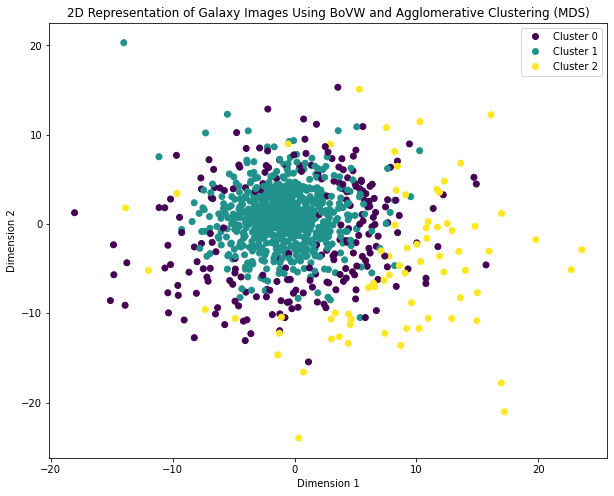

In [ ]:
# Step 4: Clustering
scaler = StandardScaler()
histograms_normalized = scaler.fit_transform(histograms)

# Using Agglomerative Clustering for final clustering
num_clusters = 3
agglo_cluster_final = AgglomerativeClustering(n_clusters=num_clusters)
clusters = agglo_cluster_final.fit_predict(histograms_normalized)

# Reduce dimensions for visualization using MDS
mds = MDS(n_components=2, random_state=42)
histograms_2d_mds = mds.fit_transform(histograms_normalized)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(histograms_2d_mds[:, 0], histograms_2d_mds[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('2D Representation of Galaxy Images Using BoVW and Agglomerative Clustering (MDS)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {i}' for i in range(num_clusters)])
plt.show()

We will try to check another method. We are going to focus on clustering by using ResNet50 model

In [ ]:
# Step 1: Load pre-trained ResNet50 model + higher level layers
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

In [ ]:
# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    return img_data

In [ ]:
features_list = []
for image_path in train_paths_2:
    img_data = load_and_preprocess_image(image_path)
    features = model.predict(img_data)
    features_list.append(features.flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━

In [ ]:
# Convert the list of features into a numpy array
features_array = np.array(features_list)

In [ ]:
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_array)

In [ ]:
# Step 4: Perform Agglomerative Clustering
num_clusters = 3
agglo_cluster = AgglomerativeClustering(n_clusters=num_clusters)
clusters = agglo_cluster.fit_predict(features_normalized)

In [ ]:
tsne = TSNE(n_components=3, random_state=42)
features_3d_tsne = tsne.fit_transform(features_normalized)

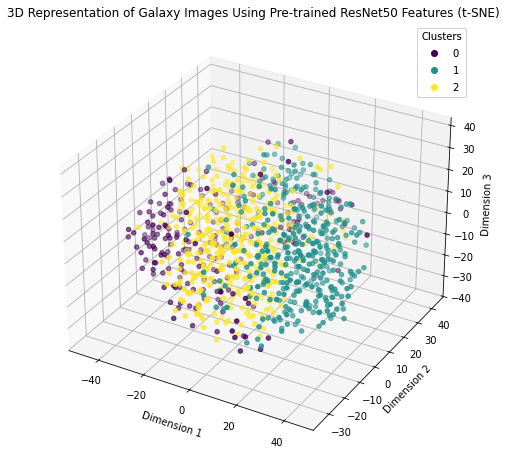

In [ ]:
# Plot the 3D representation of the images
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(features_3d_tsne[:, 0], features_3d_tsne[:, 1], features_3d_tsne[:, 2], c=clusters, cmap='viridis', marker='o')
ax.set_title('3D Representation of Galaxy Images Using Pre-trained ResNet50 Features (t-SNE)')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.show()

Now let's visualize it in 2D version

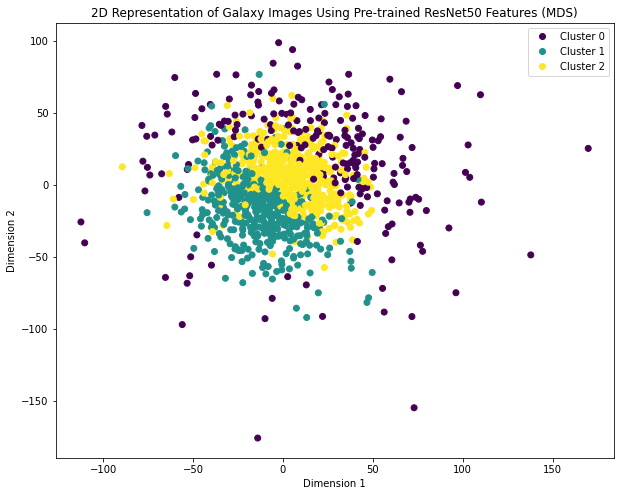

In [ ]:
mds = MDS(n_components=2, random_state=42)
features_2d_mds = mds.fit_transform(features_normalized)

# Plot the 2D representation of the images
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d_mds[:, 0], features_2d_mds[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('2D Representation of Galaxy Images Using Pre-trained ResNet50 Features (MDS)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {i}' for i in range(num_clusters)])
plt.show()

In [2]:
Transformated_IMG_Scaled_Train=np.load("Transformated_IMG_Scaled_Train.npy")
Transformated_IMG_Scaled_Test=np.load("Transformated_IMG_Scaled_Test.npy")


In [3]:
# Function to visualize clusters
def plot_clusters(data, labels, title):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', marker='o')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar()
    plt.show()

In [14]:
# Clustering models
clustering_models = {
    'KMeans': KMeans(n_clusters=3, random_state=42),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=10),
    'GaussianMixture': GaussianMixture(n_components=3, random_state=42)
}

In [7]:
train_images = Transformated_IMG_Scaled_Train.reshape((Transformated_IMG_Scaled_Train.shape[0], -1))
test_images = Transformated_IMG_Scaled_Test.reshape((Transformated_IMG_Scaled_Test.shape[0], -1))

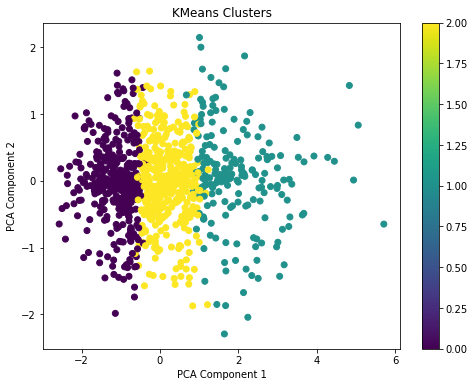

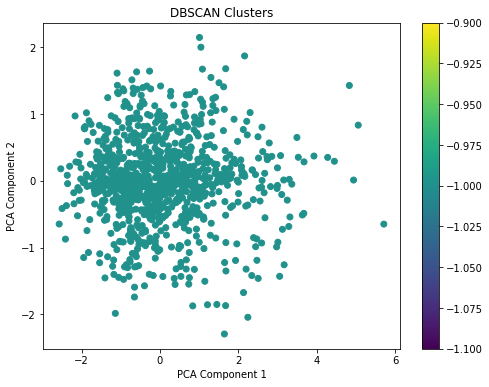

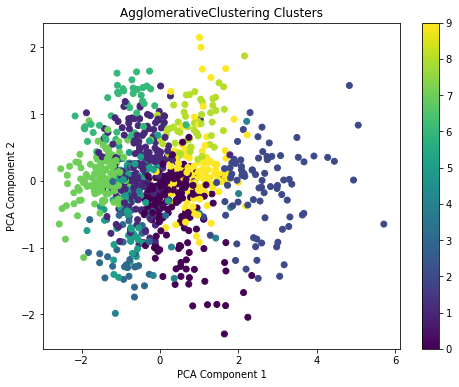

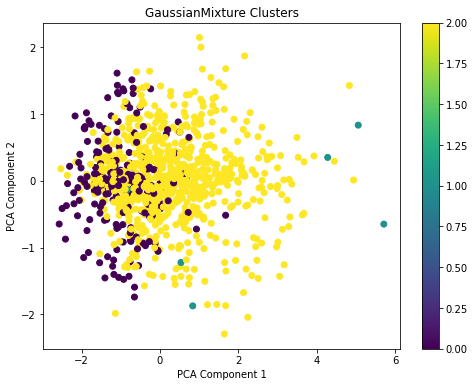

In [15]:
results = []

for model_name, model in clustering_models.items():
    # Fit the model on train images
    if model_name in ['DBSCAN', 'AgglomerativeClustering']:
        model.fit(train_images[1:1000])
        labels = model.fit_predict(test_images[1:1000])
    else:
        model.fit(train_images[1:1000])
        labels = model.predict(test_images[1:1000])
    
    # Visualize clusters
    plot_clusters(test_images[1:1000], labels, title=f'{model_name} Clusters')
    
    # Store results
    results.append({
        'Model': model_name,
        'Labels': labels
    })

In [16]:
After_Auto_Encoder_Train= np.load('After_Auto_Encoder_Train.npy')
After_Auto_Encoder_Test= np.load('After_Auto_Encoder_Test.npy')

In [ ]:
train_images_2 = After_Auto_Encoder_Train.reshape((After_Auto_Encoder_Train.shape[0], -1))
test_images_2 = After_Auto_Encoder_Test.reshape((After_Auto_Encoder_Test.shape[0], -1))